<h1>Imports y Configuraciones Iniciales</h1>

In [37]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU
from PIL import Image
import pandas as pd

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

In [38]:
TIPO_IMAGENES = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

# configurar los directorios de las imágenes

#TRAIN_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/train')
#TEST_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')

TRAIN_DIR = r"C:\Users\54934\Downloads\train"
TEST_DIR = r"C:\Users\54934\Downloads\test"

SIZE = 128

In [39]:
images_reader = ImageDataGenerator(
    rescale=1/255,  # Normaliza los píxeles a valores entre 0 y 1
    rotation_range=20,  # Rotar imágenes aleatoriamente entre 0 y 20 grados
    width_shift_range=0.2,  # Desplazar horizontalmente hasta el 20% del ancho
    height_shift_range=0.2,  # Desplazar verticalmente hasta el 20% de la altura
    shear_range=0.2,  # Cortar (shear) imágenes aleatoriamente
    zoom_range=0.2,  # Ampliar imágenes aleatoriamente
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest',  # Estrategia para rellenar nuevos píxeles
    brightness_range=(0.5, 1.5),  # Cambiar brillo aleatoriamente
    validation_split=0.2  # Porcentaje para la validación (20%)
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=TIPO_IMAGENES, # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE), # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    batch_size=32, # Tamaño del lote
)

test_dir = Path(TEST_DIR)
file_info = [{'filename': f.name, 'filepath': str(test_dir / f.name)} for f in test_dir.iterdir() if f.is_file()]
test_df = pd.DataFrame(file_info)
test = images_reader.flow_from_dataframe(dataframe=test_df, x_col='filepath', y_col=None, target_size=(SIZE, SIZE), batch_size=32, class_mode=None, shuffle=False)

Found 3000 validated image filenames.


In [40]:
# Generador para entrenamiento (80%)
train = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    **READ_PARAMS
)

# Generador para validación (20%)
validation = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    **READ_PARAMS
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [41]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(TIPO_IMAGENES[np.argmax(labels[i])])
        plt.axis("off")

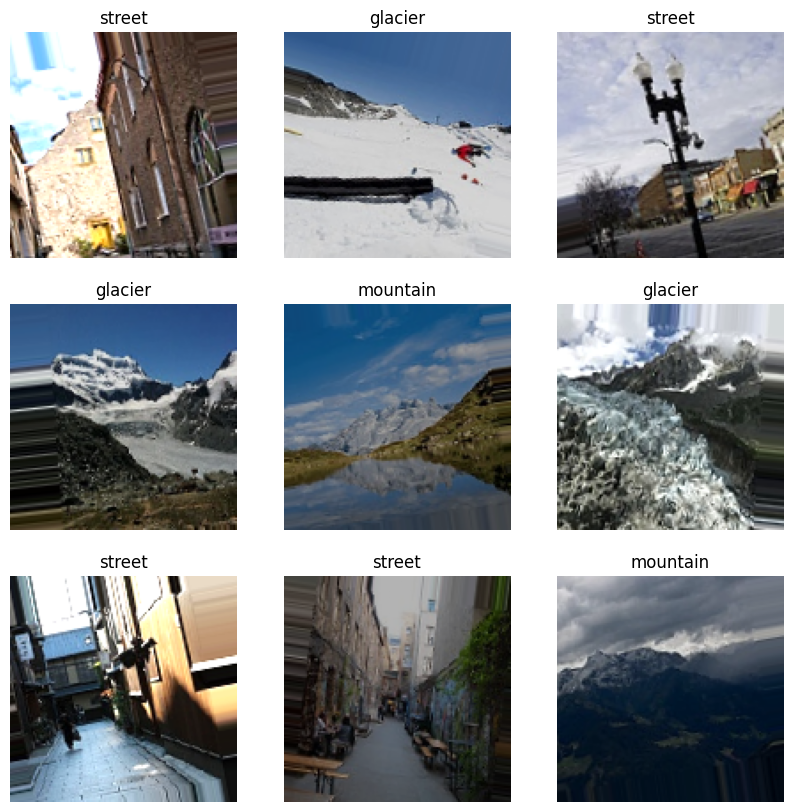

In [42]:
sample_images(train)

<h1>Análisis Exploratorio del conjunto de datos</h1>

<h2> Estructura y Formato </h2>

In [10]:
# Funcion que devuelve la estructura de 10 imágenes random de cada subcarpeta del dataset de train
import random
def image_structure_info(dataset_dir, num_examples=10):
    for root, _, files in os.walk(dataset_dir):
        if files:
            print(f"Subcarpeta: {os.path.relpath(root, dataset_dir)}")
            random_files = random.sample(files, min(num_examples, len(files)))
            for file in random_files:
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                image_format = image.format
                image_size = image.size
                print(f"- Nombre: {file}, Formato: {image_format}, Tamaño: {image_size}")

image_structure_info(TRAIN_DIR, num_examples=10)

Subcarpeta: buildings
- Nombre: 14261.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 286.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 3596.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 10032.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 17262.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 18756.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 6417.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 16466.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 4821.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 16483.jpg, Formato: JPEG, Tamaño: (150, 150)
Subcarpeta: forest
- Nombre: 6836.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 18263.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 8978.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 11262.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 4709.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 17179.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 16732.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 1063.jpg, Formato: JPE

<h3> Observaciones </h3>

Las imágenes en cada subcarpeta siguen un formato consistente (JPEG de 150x150 píxeles). Esto simplifica el preprocesamiento, ya que todas las imágenes tienen un tamaño uniforme, permitiendo entrenar el modelo sin necesidad de redimensionamiento adicional, a menos que se opte por reducir el tamaño para mejorar los tiempos de procesamiento.

<h2> Volumetría </h2>

In [11]:
# Funcion que devuelve la volumetria en los datos en el dataset de train
def dataset_volumetrics(dataset):
    num_samples = 0
    class_counts = {}
    
    for root, _, files in os.walk(dataset.directory):
        if files:
            class_name = os.path.basename(root)
            num_images = len(files)
            num_samples += num_images
            class_counts[class_name] = num_images
    
    num_classes = len(class_counts)
    
    return num_samples, num_classes, class_counts

num_samples, num_classes, class_counts = dataset_volumetrics(train)
print(f"Número total de muestras en el dataset: {num_samples}")
print(f"Número de clases en el dataset: {num_classes}")
print("Cantidad de muestras por clase:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

Número total de muestras en el dataset: 14034
Número de clases en el dataset: 6
Cantidad de muestras por clase:
- buildings: 2191
- forest: 2271
- glacier: 2404
- mountain: 2512
- sea: 2274
- street: 2382


<h3> Observaciones </h3>

Con un total de 14,034 imágenes en el conjunto de entrenamiento, el dataset tiene un tamaño suficiente para experimentar con modelos de redes neuronales profundas como CNNs. Sin embargo, dado que el tamaño de la imagen es de 150x150, podrías evaluar el tiempo de entrenamiento en modelos más complejos y considerar una reducción o técnicas de procesamiento en paralelo si los tiempos son excesivos.

<h2> Distribución de la Variable a predecir </h2>

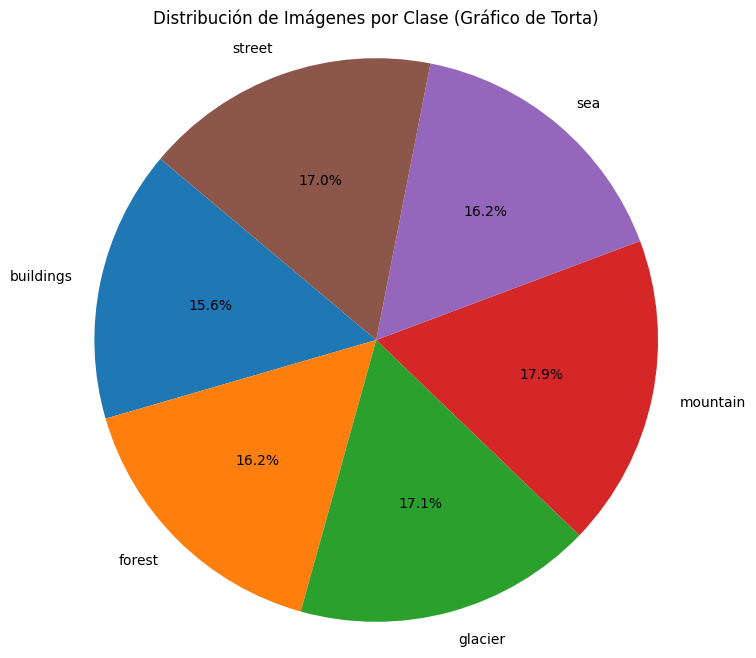

Información adicional:
Número total de clases: 6
Número total de imágenes: 14034
Clases con mayor cantidad de imágenes:
- mountain: 2512 imágenes
- glacier: 2404 imágenes
- street: 2382 imágenes
- sea: 2274 imágenes
- forest: 2271 imágenes


In [12]:
def plot_image_distribution_pie(dataset_dir):
    class_counts = {}
    
    for root, _, files in os.walk(dataset_dir):
        if files:
            class_name = os.path.basename(root)
            num_images = len(files)
            class_counts[class_name] = num_images
    
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Distribución de Imágenes por Clase (Gráfico de Torta)')
    plt.show()
    
    print("Información adicional:")
    print(f"Número total de clases: {len(class_counts)}")
    print(f"Número total de imágenes: {sum(class_counts.values())}")
    print("Clases con mayor cantidad de imágenes:")
    sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    for class_name, count in sorted_class_counts[:5]:
        print(f"- {class_name}: {count} imágenes")

# Llamar a la función con tu directorio de dataset
plot_image_distribution_pie(TRAIN_DIR)

<h3> Observaciones </h3>

La distribución de imágenes por clase es bastante balanceada, aunque algunas clases, como mountain y glacier, presentan una cantidad levemente superior de muestras. Esto sugiere que el modelo debería recibir una representación adecuada de cada categoría, lo cual es favorable para el entrenamiento, ya que reduce el riesgo de sesgo hacia una clase específica.

<h1> Modelado </h1>

In [63]:
input_shape = (SIZE, SIZE, 3)

In [ ]:
# MLP simple
model_mlp = Sequential([
    
    Input(input_shape),    
    Flatten(),
    Dense(500, activation='tanh'),
    Dropout(0.25),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_mlp.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_mlp.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Convolucional
model_convolucional = Sequential([
    
    Input(input_shape),
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),  
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),   
    MaxPooling2D(pool_size=(4, 4)),  
    Flatten(),    
    Dense(100, activation='tanh'),
    Dropout(0.25),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Convolucional con mas capas
model_convolucional_mas_capas = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(TIPO_IMAGENES), activation='softmax')
])

model_convolucional_mas_capas.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_mas_capas.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_mas_capas.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Convolucional con mas capas de dropout
model_convolucional_mas_capas_dropout = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(TIPO_IMAGENES), activation='softmax')
])

model_convolucional_mas_capas_dropout.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_mas_capas_dropout.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_mas_capas_dropout.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Convolucional usando convoluciones ya entrenadas de VGG16, con funcion de activacion "tanh"
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_vgg16_tanh: = Sequential([
    
    pretrained_model,
    Flatten(),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_vgg16_tanh.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_vgg16_tanh.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_vgg16_tanh.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Convolucional usando convoluciones ya entrenadas de VGG16 con funcion de activacion "relu"
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_mas_capas_vgg16_relu = Sequential([
    
    pretrained_model,   
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_mas_capas_vgg16_relu.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_mas_capas_vgg16_relu.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_mas_capas_vgg16_relu.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Convolucional usando convoluciones ya entrenadas de VGG16 con funcion de activacion "leakyrelu"
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_mas_capas_LeakyReLU = Sequential([
    
    pretrained_model,   
    Flatten(),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(128, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),   
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_mas_capas_LeakyReLU.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_mas_capas_LeakyReLU.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_mas_capas_LeakyReLU.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [64]:
# Modelo Xception con funcion de activacion leakyrelu, imagenes reescaladas y 10 epocas
input_shape = (150, 150, 3)  
batch_size = 128            
num_classes = len(TIPO_IMAGENES)  

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

pretrained_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')
pretrained_model.trainable = False  

model_xception = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),  
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(128, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_xception.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_xception.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

# Entrenamiento del modelo
history = model_xception.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=[early_stopping, lr_scheduler]
)

# Graficar la precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 6)               

KeyboardInterrupt: 

<h2>Conclusión: Análisis de los Modelos</h2>

En este trabajo práctico, se implementaron y probaron 8 diferentes arquitecturas de redes neuronales para clasificar imágenes en 6 categorías: edificios, bosque, glaciar, montaña, mar y calle. Los modelos evaluados fueron los siguientes:

1. **MLP simple**
2. **CNN básica**
3. **CNN con más capas/neuronas**
4. **CNN con más capas y Dropout**
5. **CNN con VGG16 (preentrenado)**
6. **CNN con VGG16 (preentrenado) y Dropout**
7. **Modelo VGG16 (con capas adicionales)**
8. **Modelo VGG16 con Dropout y más capas**

<h3>Resultados obtenidos:</h3>

Los resultados muestran que, en general, los modelos convolucionales (CNNs) lograron un mejor rendimiento que el modelo de perceptrón multicapa (MLP), lo cual es esperado dada la naturaleza de las imágenes y la capacidad de las CNNs para captar patrones espaciales. Sin embargo, dentro de las redes convolucionales, las variantes que incorporan VGG16 preentrenado mostraron una mejora significativa en comparación con las CNNs entrenadas desde cero.

<h3>Desempeño de los Modelos:</h3>

- **MLP simple**:
  - El modelo MLP mostró un desempeño moderado, con una precisión final en torno al 77% en el conjunto de validación. Si bien logró un aprendizaje adecuado, su capacidad para capturar las características espaciales y complejas de las imágenes fue limitada en comparación con las redes convolucionales.
  
- **CNN básica**:
  - Este modelo, al ser una CNN más sencilla, alcanzó una precisión de aproximadamente 76.25% en el conjunto de validación. Su desempeño fue competitivo en comparación con el MLP simple, pero aún distante de los modelos más complejos.

- **CNN con más capas/neuronas**:
  - Con una arquitectura más profunda, este modelo logró un rendimiento superior, alcanzando una precisión de alrededor del 76.8%. Aunque el aumento de la complejidad mejoró ligeramente los resultados, la red seguía enfrentando dificultades para mejorar más allá de un cierto punto.
  
- **CNN con más capas y Dropout**:
  - La introducción de Dropout para reducir el sobreajuste y mejorar la generalización resultó en una ligera mejora en comparación con el modelo anterior. Este modelo alcanzó una precisión de aproximadamente 75.68% en la validación. Aunque se observó una mejora en la regularización, los resultados siguieron siendo similares a los de modelos anteriores.

- **CNN con VGG16 preentrenado**:
  - Al usar el modelo preentrenado de VGG16, se logró una mejora sustancial en el desempeño, con una precisión de aproximadamente 81.85% en la validación. La capacidad de VGG16 para extraer características útiles de las imágenes, aprovechando pesos preentrenados en grandes bases de datos como ImageNet, fue crucial para este aumento en el rendimiento.

- **CNN con VGG16 y Dropout**:
  - La combinación de VGG16 preentrenado con Dropout resultó en un leve aumento de precisión, alcanzando un 81.85%. Esta mejora adicional sugiere que el modelo estaba evitando el sobreajuste mientras mantenía una capacidad robusta para clasificar correctamente las imágenes.


<h1>Nuestras Predicciones</h1>

In [ ]:
# nos podemos quedar con los mejores pesos, o dejarlos como están después de la última epoch
model_convolucional_vgg16.set_weights(model_weights_at_epochs[3])

In [ ]:
from IPython.display import Image, display

def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model_convolucional_vgg16.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", TIPO_IMAGENES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

In [ ]:
show_and_predict(r"C:\Users\Matias\Desktop\test\20159")

<h1>Para subir a Kaggle</h1> 

In [17]:
CSV_FILENAME = "Resultados"
MODEL = model_convolucional_mas_capas_LeakyReLU

images = []
labels = []

for image in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image)
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    images.append(image_array)

inputs = np.array(images) / 255.0

predictions = MODEL.predict(inputs)

for i, filename in enumerate(os.listdir(TEST_DIR)):
    predicted_label = TIPO_IMAGENES[np.argmax(predictions[i])]
    labels.append([filename, predicted_label])

df = pd.DataFrame(labels, columns=["ID", "Label"])
df.to_csv(CSV_FILENAME+".csv", index=False)